In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [49]:
def kernel(x, x_prime, theta_1=1, theta_2=0.4, theta_3=0.1):
    if x == x_prime:
      delta = 1
    elif x != x_prime:
      delta = 0
    return theta_1 * np.exp(- (x-x_prime)**2 / theta_2) + theta_3 * delta

def GP_regression(x_train, y_train, x_test):
    N = len(x_train)
    M = len(x_test)
    K = np.zeros((N,N))
    k = np.zeros(N)
    mu = np.zeros(M)
    var = np.zeros(M)

    for i in range(N):
      for j in range(N):
          K[i][j] = kernel(x_train[i],x_train[j])
    K_inv = np.linalg.inv(K)
    yy = np.dot(K_inv, y_train)

    for i in range(M):
      for j in range(N):
        k[j] = kernel(x_train[j], x_test[i])
      s = kernel(x_test[i],x_test[i])
      mu[i] = np.dot(k.T,yy)
      var[i] = s - np.dot(np.dot(k.T, K_inv), k)
      
    return mu, var


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


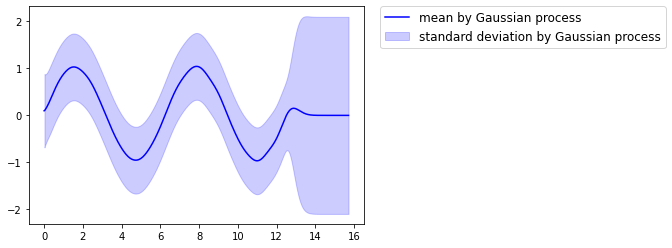

In [50]:
# ガウス過程回帰ができているか実験

x = np.linspace(0,5*np.pi, 1000)
x_train = np.linspace(0, 4*np.pi, 100)
y_train = np.sin(x_train) + np.random.rand(100) * 0.1
mu, var = GP_regression(x_train, y_train, x)


std = np.sqrt(var)
plt.plot(x, mu, color='blue', label='mean by Gaussian process')
plt.fill_between(x, mu + 2*std, mu - 2*std, alpha=.2, color='blue', label= 'standard deviation by Gaussian process')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()

# 平均値±(標準偏差×2) … 95.4%の確率で範囲内に指定の数値が現れる

In [65]:
def make_graph_of_GP_regression(x,mu,var,x_train, y_train, index):
  plt.clf()
  std = np.sqrt(var)
  plt.plot(x, mu, color='blue', label='mean by Gaussian process')
  plt.plot(x_train, y_train, "x")
  plt.fill_between(x, mu + 2*std, mu - 2*std, alpha=.2, color='blue', label= 'standard deviation by Gaussian process')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
  plt.savefig("check{}.png".format(index))

In [95]:
def build_acquisition_function(mu, var, beta=2):
  a = mu + np.sqrt(np.log(beta) / beta) * var
  return a

def optimize_acquisition_function(a):
  max_index = []
  for i, x in enumerate(a):
    if x == max(a):
      max_index.append(i)
  return max_index

In [96]:
def Bayesian_optimization(x_train, y_train, N=10):
  n = 1000
  x = np.linspace(0,4*np.pi, n)
  for i in range(N):
    # print("現在 {}回目の実験です。".format(i))
    mu, var = GP_regression(x_train, y_train, x)
    if i+1 % 20 == 0:
      make_graph_of_GP_regression(x,mu,var,x_train, y_train, i)
    a = build_acquisition_function(mu, var)
   
    max_index = optimize_acquisition_function(a)
    # print(max_index)   
    # x_next = np.argmax(a)とすると、x_nextがx_train内にある点になる可能性がある。x_train内にある点になると、Kの逆行列が求められず、エラーを吐く。
    # x_next = x[np.argmax(a)]
    for j in range(len(max_index)):
      if x[max_index[j]] in x_train:
        # print("argmaxの出力が観測点集合内の要素になっています")
        # print("max_indexの要素は", len(max_index))
        if j != len(max_index)-1:
          # print("continueします")
          continue
        elif j == len(max_index)-1:
          # print("argmaxの出力で観測できるものがありませんでした")
          for k in range(n):
            x_next = x[random.randint(0, n-1)]
            if x_next not in x_train:
              break

      elif x[max_index[j]] not in x_train:
        x_next = x[max_index[j]]
        break
    # print(x_next)
    y = np.sin(x_next) + np.random.rand() * 0.01
    # print("x_next is here", x_next)
    # print("y is here", y)
    x_train = np.append(x_train, x_next)
    y_train = np.append(y_train, y)
  return x_train, y_train

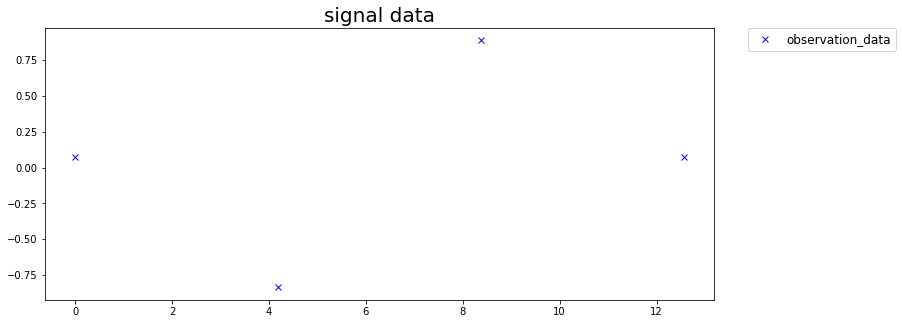

In [97]:
import numpy as np
import random
n = 4

x_train = np.linspace(0, 4*np.pi, n)
y_train = np.sin(x_train) + np.random.rand(n) * 0.1


from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 5))
plt.title('signal data', fontsize=20)

# 元の信号
plt.plot(x_train, y_train, 'x', color='blue', label='observation_data')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()

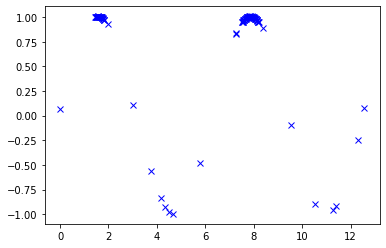

In [98]:
D_x, D_y = Bayesian_optimization(x_train, y_train, N=100)
plt.plot(D_x, D_y, 'x', color='blue', label='correct signal')
plt.show()